In [1]:
# EXECUTE THIS CELL
! pip install lammps -q
! pip install git+https://github.com/henriasv/lammps-logfile.git


import pandas as pd
import re
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")
import lammps_logfile
from lammps import lammps

  Cloning https://github.com/henriasv/lammps-logfile.git to /private/var/folders/kr/hd4z04ps7gj0rkc4v2688f9m0000gn/T/pip-req-build-uezvi8z5
  Running command git clone --filter=blob:none --quiet https://github.com/henriasv/lammps-logfile.git /private/var/folders/kr/hd4z04ps7gj0rkc4v2688f9m0000gn/T/pip-req-build-uezvi8z5
  Resolved https://github.com/henriasv/lammps-logfile.git to commit d31b1fb0ae9896507c00877dfca48b05bfdc534e
  Preparing metadata (setup.py) ... done


# Exercise: Diffusion of Hydrogen in Palladium

Molecular dynamics (MD) simulations are a powerful tool for understanding the atomic-scale mechanisms that underlie real-world materials behavior. In fields like hydrogen storage, fuel cells, and catalysis, the ability of hydrogen to diffuse through metals such as palladium is of critical importance. However, these processes are difficult to observe directly at the atomic level.

In this exercise, you will study the diffusion of hydrogen (H) atoms in a palladium (Pd) matrix using molecular dynamics simulations. Palladium has a face-centered cubic (FCC) structure, and hydrogen atoms occupy interstitial sites, forming an interstitial solid solution.

You are provided with equilibrated atomic configurations of Pd with a dilute concentration of hydrogen (`PdH_equilibrated_*.data`) at different temperatures (350 K, 400 K, 450 K, 500 K). Your task is to analyze how hydrogen atoms move through the Pd lattice over time, and to extract physical insights about the diffusion process.

Specifically, you will:

- Perform molecular dynamics simulations at different temperatures,

- Load time-resolved mean squared displacement (MSD) data for H atoms,

- Fit a linear model to the MSD vs. time curves to determine diffusion coefficients at each temperature,

- Construct an Arrhenius plot of $\ln D$ vs. $1/T$ to extract the activation energy for hydrogen diffusion in palladium.

<div style="text-align: center;">
  <img src="PdH_crop.gif" style="width: 500px;">
  <p style="font-size: 0.9em; text-align: center;">
    Hydrogen diffusion in a palladium (Pd) matrix. Hydrogen atoms (black) move through the semitransparent grey Pd lattice, with their trajectories visualized as they evolve over time.
  </p>
</div>

# (a) Production runs

## 350 K

1. In the cell below, insert your matriculation number at the end of the line `variable    randomSeed equal`
    - This step ensures the reproducibility of your simulation results.

2. Execute the cell to generate a LAMMPS input script for a simulation at 350 K.  

3. Then run the next cell to submit the simulation.

4. Make note of the files and associated properties generated during the simulation.

5. Once the simulation at 350 K is complete, duplicate both cells and adapt them to run simulations at the other temperatures of interest: 400 K, 450 K, and 500 K.

    > **Important:**  
    > Make sure to update all temperature-specific values in both the input script and the submission command, including:
    > - The target temperature,
    > - Output file names (to avoid overwriting),
    > - Any labels used in filenames, variables, or logs.

In [2]:
%%writefile PdH_350.in
# Set up units and boundaries
units       metal
boundary    p p p
atom_style  atomic

# Read input data
read_data   PdH_equilibrated_350.data

# Define masses for atomic types
mass 1      1.00794  # H
mass 2      106.42  # Pd 

pair_style eam/alloy
pair_coeff * * PdH_Zhou_June29_2007_2.eam.alloy H Pd

##################################
# Parameters #
variable    randomSeed equal        40       # Your matriculation number  
variable    timeStepLength equal    0.001    # In ps
variable    tDamp equal             0.1      # Thermostat damping (ps)
variable    pDamp equal             1        # Barostat damping (ps)
variable    startingTemp equal      350      # Initial temperature in K
variable    externalPressure equal  0.0      # External pressure in atm
variable    run1 equal              50000   # Steps 
##################################

group Hatoms    type 1 
compute         Hmsd Hatoms msd com yes
variable        time equal step*${timeStepLength}

fix msdout all ave/time 100 1 100 c_Hmsd[4] file msd_H_350.txt

# Set timestep
timestep    ${timeStepLength}

# Starting simulation

thermo_style custom step temp press ke pe etotal vol enthalpy c_Hmsd[*]
thermo_modify flush yes
thermo 100

dump        dump1 all custom 5000 350.traj.dump id type x y z

# Step 1: 
fix         1 all npt temp ${startingTemp} ${startingTemp} ${tDamp} iso ${externalPressure} ${externalPressure} ${pDamp}
run         ${run1}
unfix       1

Writing PdH_350.in


In [ ]:
# EXECUTE THIS CELL
lmp = lammps(cmdargs=["-log", "PdH_350.log"])
lmp.file("PdH_350.in")

## 400 K

## 450 K

## 500 K

# (b) Harvest MSD data

In this step, you will load the MSD data for hydrogen diffusion from your simulations at different temperatures, merge them into a single DataFrame, and create a time axis.

1. Identify the correct output files for each temperature. You can find the filenames either in your LAMMPS input scripts or directly in your working folder.  
Then, replace `'name of the text file'` with the actual filenames in the code snippet below.

2. Use the provided snippet to:
    - Load each file using `pd.read_csv`,
    - Merge the DataFrames on the `Step` column (which represents simulation time steps),
    - Convert the timestep to time in picoseconds,
    - Reorder columns for clarity.

3. Execute the cell once all file names are correctly inserted. You should see a table with time and MSD values at all four temperatures.

If you are proficient in Python, feel free to implement your own solution using loops or functions, as long as the final output matches the expected format.

In [2]:
# COMPLETE AND EXECUTE THIS CELL

# Time conversion: 1 timestep = 1 fs = 0.001 ps
timestep_fs = 1
fs_to_ps = 0.001

# Load all MSD files
df_350 = pd.read_csv('NAME OF THE FILE', comment='#', sep='\s+', names=['Step','MSD 350K'])
# df_400 = 
# ...
# ...

# Merge on Step
df = df_350.merge(df_400, on='Step').merge(df_450, on='Step').merge(df_500, on='Step')

# Add Time column in ps
df['Time [ps]'] = df['Step'] * timestep_fs * fs_to_ps

# Reorder columns
df = df[['Step', 'Time [ps]', 'MSD 350K', 'MSD 400K', 'MSD 450K', 'MSD 500K']]


# Show result
df

,Step,Time [ps],MSD 350K,MSD 400K,MSD 450K,MSD 500K
0,0,0.0,7.936670e-29,3.623540e-29,5.465080e-29,2.617350e-30
1,100,0.1,4.335340e-01,3.517140e-01,5.477390e-01,4.216280e-01
2,200,0.2,5.377310e-01,4.748420e-01,9.318090e-01,6.213570e-01
3,300,0.3,7.255200e-01,6.261740e-01,1.258270e+00,8.770060e-01
4,400,0.4,7.344140e-01,7.487240e-01,1.510420e+00,1.506470e+00


This DataFrame presents mean squared displacement (MSD) data over time for different temperatures.

  * `Step`: Simulation step index.

  * `Time [ps]`: Time in picoseconds corresponding to each simulation step.
  
  * `MSD 350K` to `MSD 500K`: Mean squared displacement values at 350K, 400K, 450K, and 500K, respectively.


Now, complete the code snippet below to plot all the MSD datasets on a single graph.

- Replace `'header of the x column'` and `'header of the y column'` with the exact column names from the DataFrame that you want to plot. Make sure the names match the DataFrame headers exactly.

- You will need to do this four times: once for each temperature dataset.

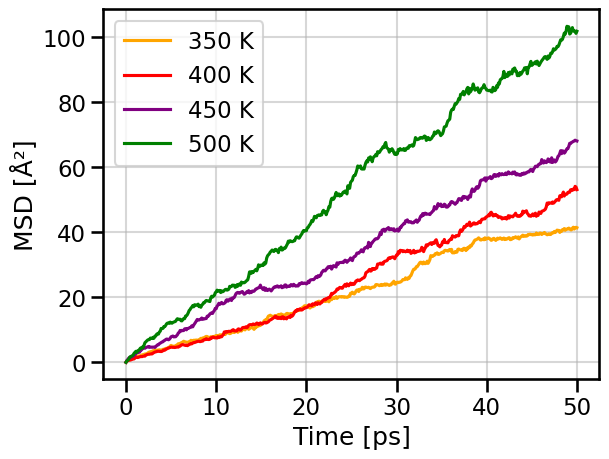

In [ ]:
# COMPLETE AND EXECUTE THIS CELL

sns.lineplot(data=df, x='header of the x column', y='header of the y column', label='temperature value')   # data for 350 K
# data for 400 K
# data for 450 K
# data for 500 K


plt.xlabel('Time [ps]')
plt.ylabel(r'MSD [$\mathrm{\AA^2}$]')

plt.grid(True, alpha=0.5)
plt.show()

## (c) Calculate diffusion coefficients

Calculate the diffusion coefficient at the given temperatures by applying Einstein’s relation with $d=3$:
$$
\text{MSD}(t) = 2dDt
$$

The diffusion coefficient is extracted from the slope of the MSD vs. time curve, which we expect to be linear at long times:
$$
\text{MSD}(t) = a \cdot t + b
$$

> Think about the physical meaning of MSD at time $t=0$.
> What value should the MSD have at the very beginning of the simulation?
> What does that tell you about the constant `b`?

Below is a generic function you can use for curve fitting: adapt it according to your answer to the previous question.

In [ ]:
# ADAPT AND EXECUTE THIS CELL

# Linear model: MSD(t) = a * t + b
def msd_model(t, a, b):
    return a * t + b

<details>
<summary>Spoiler Alert</summary>

If you reasoned that MSD should be zero at $t = 0$, you're right! Here's a simplified model that reflects that:

```python
# MSD(t) = a * t, with zero intercept
def msd_model(t, a):
    return a * t
```
</details> 

Adapt the following code snippet to extract the diffusion coefficient $D$ at each temperature using your merged DataFrame.

- Replace `'header of the x column'` with `'Time [ps]'`.

- Replace `'header of the y column'` with the MSD column corresponding to the temperature you're working with (e.g., `'MSD 350K'`).

- Set the correct dimensionality of the system, so the denominator becomes $2d$ in the Einstein relation.

Repeat this process for the other temperatures by adapting the MSD column name and label in `print()`.

Bonus: Try fitting with and without the intercept. Do you see a difference in extracted $D$?
What might cause a non-zero intercept?

In [ ]:
# COMPLETE AND EXECUTE THIS CELL

d = ... # dimensionality of the system

### data for 350 K
t = df['header of the x column']
msd_350 = df['header of the y column']

# Fit and extract D
popt_350, _ = curve_fit(msd_model, t, msd_350)

D_350 = popt_350[0] / 2*d

print(f"T = 350 K: D = {D_350:.2e} Å²/ps")


### data for 400 K
# ...

### data for 450 K
# ...

### data for 500 K
# ...

## (d) Arrhenius fitting

Now that you've extracted the diffusion coefficients $D$ at different temperatures, it's time to organize your results in a table so you can use them for further analysis (like Arrhenius fitting).

1. Replace the placeholder list of `temperatures` with the actual values used in your simulations (e.g., `350`).

2. Replace the list of `diffusion_coeffs` with the actual *variable names* (not the numerical values) you defined for each diffusion coefficient (e.g., `D_350`).

3. Run the cell to create a new DataFrame `df_diffusion_fits` with:
    - Temperature
    - Diffusion coefficient
    - Inverse temperature 
    - Natural logarithm of the diffusion coefficient 

In [ ]:
# COMPLETE AND EXECUTE THIS CELL

# Lists of values (to complete)
temperatures = [temperatures values separated by commas]
diffusion_coeffs = [variable names of the diffusion coefficients, separated by commas]

# Create the DataFrame
df_diffusion_fits = pd.DataFrame({
    'T [K]': temperatures,
    'D [Å²/ps]': diffusion_coeffs
})

# Add derived columns
df_diffusion_fits['1/T [1/K]'] = 1 / df_diffusion_fits['T [K]']
df_diffusion_fits['ln D'] = np.log(df_diffusion_fits['D [Å²/ps]'])

# Show it
df_diffusion_fits

In [ ]:
# Lists of values
temperatures = [350, 400, 450, 500]
diffusion_coeffs = [D_350, D_400, D_450, D_500]

# Create the DataFrame
df_diffusion_fits = pd.DataFrame({
    'T [K]': temperatures,
    'D [Å²/ps]': diffusion_coeffs
})

# Add derived columns
df_diffusion_fits['1/T [1/K]'] = 1 / df_diffusion_fits['T [K]']
df_diffusion_fits['ln D'] = np.log(df_diffusion_fits['D [Å²/ps]'])

# Show it
df_diffusion_fits

,T [K],D [Å²/ps],1/T [1/K],ln D
0,350,0.146816,0.002857,-1.918573
1,400,0.172602,0.002500,-1.756769
2,450,0.225953,0.002222,-1.487429
3,500,0.349743,0.002000,-1.050557


Complete and execute the following snippet to fit the natural logarithm of the diffusion coefficient $\ln D$ to a linear function of inverse temperature $1/T$, based on the Arrhenius equation:
$$
\ln D = \ln D_0 - \frac{E_a}{k_B T}
$$

Be sure to input the correct column headers from the previous DataFrame where required.

This allows you to extract two important physical parameters:

- $D_0$: the pre-exponential factor (diffusivity at infinite temperature),

- $E_a$: the activation energy (energy barrier for diffusion), in eV.

In [ ]:
# COMPLETE AND EXECUTE THIS CELL
# Extract values
invT = df_diffusion_fits['header of the x column']
lnD = df_diffusion_fits['header of the y column']

# Define linear Arrhenius model
def arrhenius_ln(invT, slope, intercept):
    return slope * invT + intercept

# Fit
popt, _ = curve_fit(arrhenius_ln, invT, lnD)
slope, intercept = popt

# Extract physical parameters
kB = 8.617e-5  # eV/K
Ea_eV = -slope * kB
D0 = np.exp(intercept)

print(f"Fitted activation energy Ea = {Ea_eV:.3f} eV")
print(f"Fitted pre-exponential factor D0 = {D0:.2e} Å²/ps")

Fitted activation energy Ea = 0.084 eV
Fitted pre-exponential factor D0 = 2.18e+00 Å²/ps


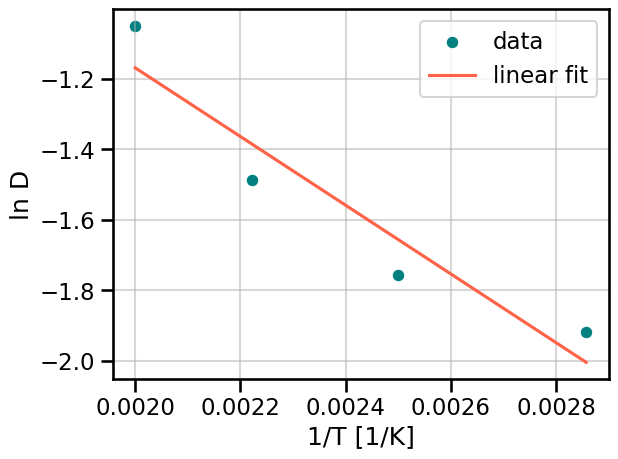

In [ ]:
# EXECUTE THIS CELL
sns.scatterplot(x=invT, y=lnD, label='data', color='teal')
sns.lineplot(x=invT, y=arrhenius_ln(invT, slope, intercept), label='linear fit', color='tomato')

plt.xlabel('1/T [1/K]')
plt.ylabel('ln D')

plt.grid(True, alpha=0.5)
plt.legend()
plt.show()